# Disease Prediction Model Using Gradient Boosting Algorithms

## Project Overview
This notebook implements machine learning models for predicting diseases based on patient symptoms. We compare three gradient boosting algorithms (XGBoost, LightGBM, and CatBoost) to identify which performs best for this medical diagnostic task.

## Dataset Information
- **Source**: Preprocessed medical diagnostic data
- **Features**: 133 binary symptom indicators (e.g., fever, headache, cough)
- **Target**: 41 unique disease classifications
- **Size**: 304 patient records

## Project Goals
1. Build accurate disease prediction models using gradient boosting algorithms
2. Compare performance across multiple metrics (accuracy, overfitting, robustness)
3. Identify the most important symptoms for disease diagnosis
4. Select the best model for potential deployment in medical applications

## Methodology
We follow a comprehensive approach including:
- Exploratory data analysis
- Model training and evaluation
- Overfitting analysis
- Cross-validation
- Feature importance analysis
- Robustness testing with simulated noise

Let's begin by importing the necessary libraries and loading our dataset.

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Model imports
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Set random seed for reproducibility
np.random.seed(42)

#warning
import warnings
warnings.filterwarnings("ignore")

## 1. Data Loading and Exploration

In this section, we load the preprocessed dataset and perform initial exploratory data analysis to understand:
- The shape and size of our dataset
- The distribution of diseases (target variable)
- Basic statistics of the symptom features

This helps us understand the data structure before building our prediction models.

In [4]:
# Load the preprocessed dataset
data = pd.read_csv("../data/cleaned_data.csv")

# Split into features (X) and target (y)
X = data.drop("prognosis", axis=1)  # Features (symptoms)
y = data["prognosis"]               # Target (disease)

# Display basic dataset information
print(f"Dataset shape: {data.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of unique diseases: {y.nunique()}")

# Preview the data
display(data.head())

Dataset shape: (304, 133)
Number of features: 132
Number of unique diseases: 41


itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
0       0           0             0        0                 0  ...   
1       0           0             0        0                 0  ...   
2       0           0             0        0                 0  ...   
3       0           0             0        0                 0  ...   
4       0           0             0        0                 0  ...   

   blackheads  scurring  skin_peeling  silver_like_dusting  \
0           0         0             0                    0   
1           0         0             0                    0   
2           0         0             0                    0   
3           0         0             0                    0   
4           0         0             0                    0   

   small_dents_in_nails  inflammatory_nails  blister  red_sore_around_nose  \
0                     0                   0        0                     0   
1                     0                   0        0                     0   
2                     0                   0        0                     0   
3                     0                   0        0                     0   
4                     0                   0        0                     0   

   yellow_crust_ooze         prognosis  
0                  0  Fungal infection  
1                  0  Fungal infection  
2                  0  Fungal infection  
3                  0  Fungal infection  
4                  0  Fungal infection  

[5 rows x 133 columns]

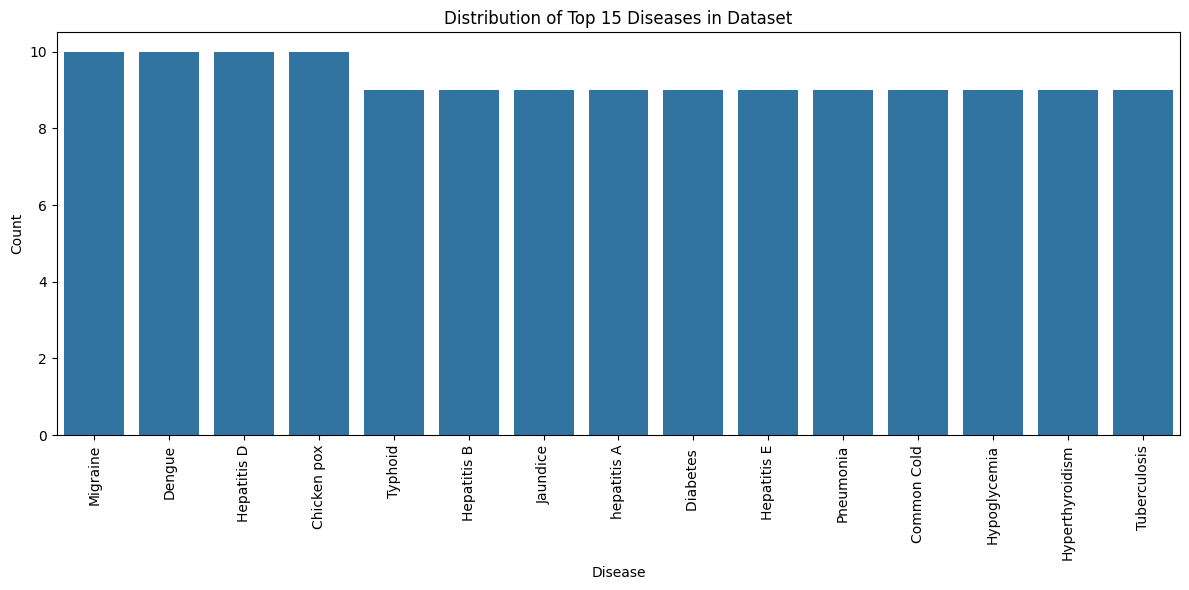

Most common disease: Migraine (10 instances)
Least common disease: Gastroenteritis (5 instances)
Average instances per disease: 7.4


In [3]:
# Analyze class distribution
disease_counts = y.value_counts().sort_values(ascending=False)

# Plot the distribution of diseases
plt.figure(figsize=(12, 6))
sns.barplot(x=disease_counts.index[:15], y=disease_counts.values[:15])
plt.title('Distribution of Top 15 Diseases in Dataset')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print class balance statistics
print(f"Most common disease: {disease_counts.idxmax()} ({disease_counts.max()} instances)")
print(f"Least common disease: {disease_counts.idxmin()} ({disease_counts.min()} instances)")
print(f"Average instances per disease: {y.shape[0]/y.nunique():.1f}")

## 2. Data Preprocessing and Train-Test Split

This section prepares our data for machine learning:
- Encoding categorical disease labels to numeric values using `LabelEncoder`
- Splitting the dataset into training (80%) and testing (20%) sets
- Using stratification to maintain class distribution in both sets

Proper preprocessing and splitting are crucial for ensuring model performance reflects real-world conditions.

In [7]:
# Encode categorical disease labels to numeric values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Original first 5 labels: {y.values[:5]}")
print(f"Encoded first 5 labels: {y_encoded[:5]}")
print(f"Total number of encoded classes: {len(le.classes_)}")

# Split data into training and test sets (80/20 split with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2,           # 20% for testing
    random_state=42,         # For reproducibility
    stratify=y_encoded       # Maintain class distribution in both sets
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Check class distribution in train/test sets
train_class_counts = pd.Series(y_train).value_counts()
test_class_counts = pd.Series(y_test).value_counts()

print(f"Number of classes in training set: {len(train_class_counts)}")
print(f"Number of classes in test set: {len(test_class_counts)}")

Original first 5 labels: ['Fungal infection' 'Fungal infection' 'Fungal infection'
 'Fungal infection' 'Fungal infection']
Encoded first 5 labels: [15 15 15 15 15]
Total number of encoded classes: 41
Training set shape: (243, 132)
Test set shape: (61, 132)
Number of classes in training set: 41
Number of classes in test set: 41


## 3. Model Definition and Hyperparameters

In this section, we define three gradient boosting models:
1. **XGBoost** - Known for speed and performance
2. **LightGBM** - Designed for efficiency with larger datasets
3. **CatBoost** - Often performs well with categorical features and minimal tuning

Each model is configured with carefully selected hyperparameters to balance complexity, learning rate, and tree depth. These settings impact the model's ability to generalize from training data.

In [5]:
# Define the three gradient boosting models we'll compare
models = {
    "xgb": xgb.XGBClassifier(
        n_estimators=200,        # Number of gradient boosted trees
        learning_rate=0.05,      # Shrinkage parameter to prevent overfitting
        max_depth=5,             # Maximum tree depth
        subsample=0.8,           # Fraction of samples used for fitting individual trees
        colsample_bytree=0.8,    # Fraction of features used for individual trees
        random_state=42,         # For reproducibility
        use_label_encoder=False, # Avoid warning
        eval_metric="mlogloss",   # Multiclass log loss
        verbosity=0
    ),
    
    "lgb": lgb.LGBMClassifier(
        n_estimators=200,        # Number of boosting rounds
        learning_rate=0.05,      # Step size shrinkage
        max_depth=-1,            # Unlimited depth for LightGBM
        subsample=0.8,           # Subsample ratio of training data
        colsample_bytree=0.8,    # Subsample ratio of columns
        random_state=42,         # For reproducibility
        verbosity=0               # Suppress warnings (uncomment if needed)
    ),
    
    "cat": CatBoostClassifier(
        iterations=200,          # Number of boosting iterations
        learning_rate=0.05,      # Learning rate
        depth=6,                 # Depth of trees
        random_state=42,         # For reproducibility
        verbose=0                # Suppress training output
    )
}

# Display the models and their key parameters
for name, model in models.items():
    print(f"{name.upper()} model parameters:")
    for param, value in model.get_params().items():
        if param in ['n_estimators', 'iterations', 'learning_rate', 'max_depth', 'depth']:
            print(f"  - {param}: {value}")

XGB model parameters:
  - learning_rate: 0.05
  - max_depth: 5
  - n_estimators: 200
LGB model parameters:
  - learning_rate: 0.05
  - max_depth: -1
  - n_estimators: 200
CAT model parameters:
  - iterations: 200
  - learning_rate: 0.05
  - depth: 6


## 4. Model Training and Evaluation

Here we train each model on the training data and evaluate performance on the test set:
- Train each model on the same training data
- Make predictions on the test set
- Calculate accuracy and detailed classification metrics
- Save trained models for later use

This initial evaluation helps us understand each model's raw predictive performance before more detailed analysis.

In [6]:
# Dictionary to store model results
model_results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n🚀 Training {name.upper()}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    
    # Convert numeric predictions back to original disease names for interpretability
    y_pred_labels = le.inverse_transform(y_pred)
    y_test_labels = le.inverse_transform(y_test)
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    model_results[name] = acc
    
    # Display results
    print(f"✅ {name.upper()} Accuracy: {acc:.4f}")
    
    # Generate detailed classification report
    print(f"\n{name.upper()} Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))
    
    # Save model for later use
    joblib.dump(model, f"../models/{name}_disease_model.pkl")

# Save the label encoder for future predictions
joblib.dump(le, "../models/label_encoder.pkl")
print("\n✓ All models + encoder saved successfully!")


🚀 Training XGB...
✅ XGB Accuracy: 0.9836

XGB Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         2
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         2
                    Chronic cholestasis       0.67      1.00      0.80         2
                            Common Col

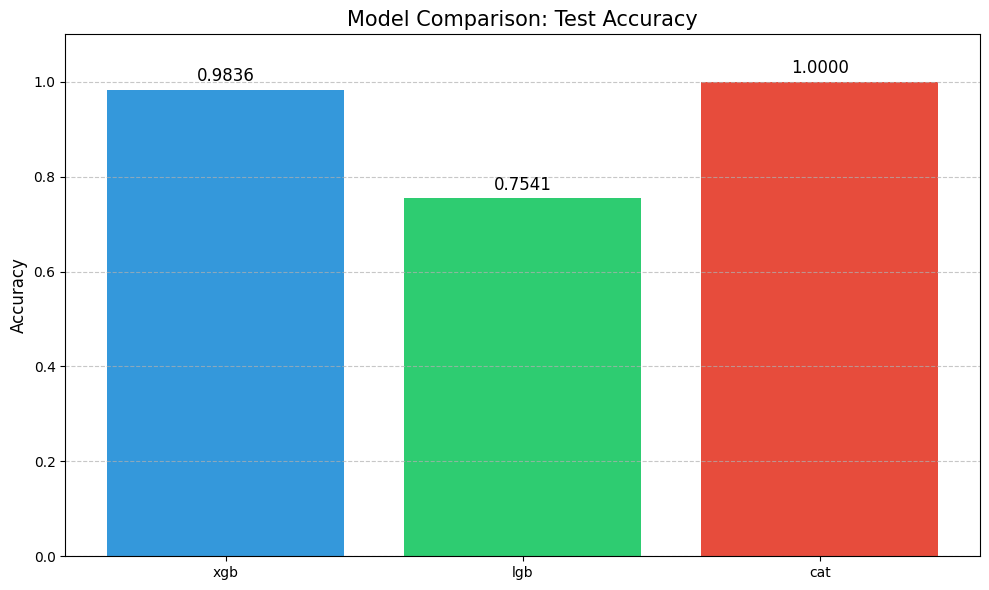


🏆 Best performing model: CAT with accuracy 1.0000


In [7]:
# Visualize model accuracies
plt.figure(figsize=(10, 6))
model_names = list(model_results.keys())
accuracies = [model_results[model] for model in model_names]

# Create a bar chart
bars = plt.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=12)

plt.title('Model Comparison: Test Accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.1)  # Set y-axis to go from 0 to 1.1 for visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print the winning model
best_model = max(model_results.items(), key=lambda x: x[1])
print(f"\n🏆 Best performing model: {best_model[0].upper()} with accuracy {best_model[1]:.4f}")

## 5. Model Validation and Overfitting Analysis

Overfitting occurs when models perform well on training data but poorly on new data. In this section, we:
- Evaluate models on both training and test sets
- Calculate the gap between training and test accuracy
- Visualize differences to detect potential overfitting
- Identify which model generalizes best

This analysis is especially important in medical applications where generalization to new patients is critical.

Model    | Train Accuracy | Test Accuracy | Gap (Train-Test)
-------------------------------------------------------
XGBoost  | 1.0000        | 0.9836       | 0.0164
LightGBM | 0.8724        | 0.7541       | 0.1183
CatBoost | 1.0000        | 1.0000       | 0.0000


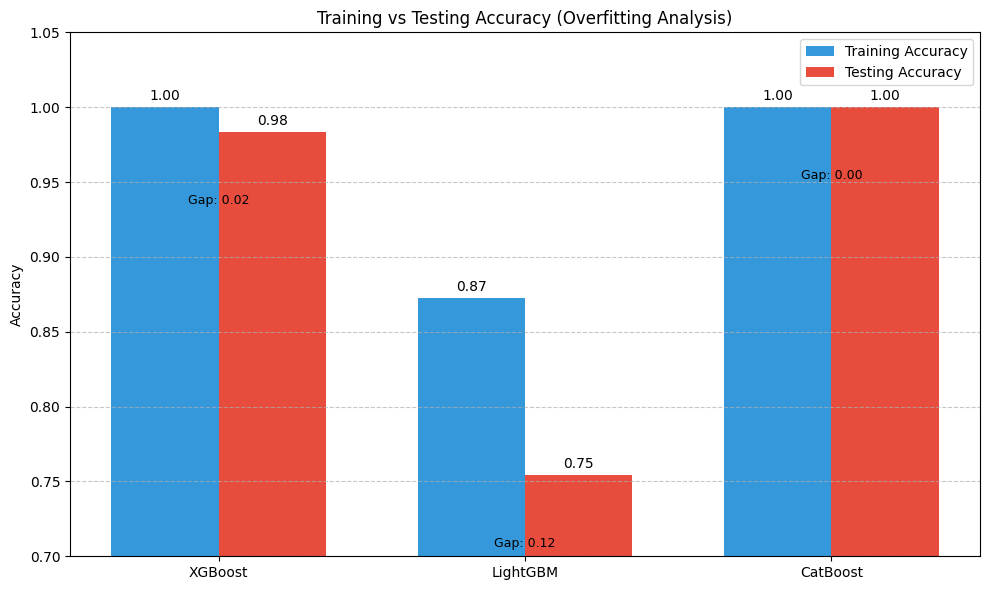


Model with least overfitting: CatBoost (Gap: 0.0000)


In [8]:
# Load the saved models for detailed analysis
xgb_model = joblib.load("../models/xgb_disease_model.pkl")
lgb_model = joblib.load("../models/lgb_disease_model.pkl")
cat_model = joblib.load("../models/cat_disease_model.pkl")

# Function to evaluate model on both train and test data
def evaluate_overfitting(model, X_train, y_train, X_test, y_test):
    """Evaluate a model's performance on both training and test sets to detect overfitting"""
    # Training accuracy
    train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    
    # Testing accuracy
    test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    
    # Calculate gap (potential overfitting indicator)
    gap = train_acc - test_acc
    
    return train_acc, test_acc, gap

# Compare train vs test accuracy for all models
results = []
for name, model in [("XGBoost", xgb_model), ("LightGBM", lgb_model), ("CatBoost", cat_model)]:
    train_acc, test_acc, gap = evaluate_overfitting(model, X_train, y_train, X_test, y_test)
    results.append((name, train_acc, test_acc, gap))

# Display results
print("Model    | Train Accuracy | Test Accuracy | Gap (Train-Test)")
print("-" * 55)
for name, train_acc, test_acc, gap in results:
    print(f"{name:<9}| {train_acc:.4f}        | {test_acc:.4f}       | {gap:.4f}")

# Visualize train-test accuracy differences
models = [r[0] for r in results]
train_scores = [r[1] for r in results]
test_scores = [r[2] for r in results]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

train_bars = ax.bar(x - width/2, train_scores, width, label='Training Accuracy', color='#3498db')
test_bars = ax.bar(x + width/2, test_scores, width, label='Testing Accuracy', color='#e74c3c')

ax.set_ylabel('Accuracy')
ax.set_title('Training vs Testing Accuracy (Overfitting Analysis)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0.7, 1.05)  # Set y limit for better visibility
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add text annotations
for i, (train_bar, test_bar) in enumerate(zip(train_bars, test_bars)):
    train_height = train_bar.get_height()
    test_height = test_bar.get_height()
    gap = train_height - test_height
    
    ax.annotate(f'{train_height:.2f}',
                xy=(train_bar.get_x() + train_bar.get_width()/2, train_height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
    
    ax.annotate(f'{test_height:.2f}',
                xy=(test_bar.get_x() + test_bar.get_width()/2, test_height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
    
    ax.annotate(f'Gap: {gap:.2f}',
                xy=(x[i], min(train_height, test_height) - 0.05),
                ha='center', va='bottom',
                fontsize=9)

plt.tight_layout()
plt.show()

# Check for model with smallest train-test gap (least overfitting)
min_gap_model = min(results, key=lambda x: x[3])
print(f"\nModel with least overfitting: {min_gap_model[0]} (Gap: {min_gap_model[3]:.4f})")

Cross-Validation Results (5-fold):
----------------------------------------------------------------------
Model    | Mean Accuracy | Standard Deviation
----------------------------------------------------------------------
XGBoost  | 0.9836       | 0.0104
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

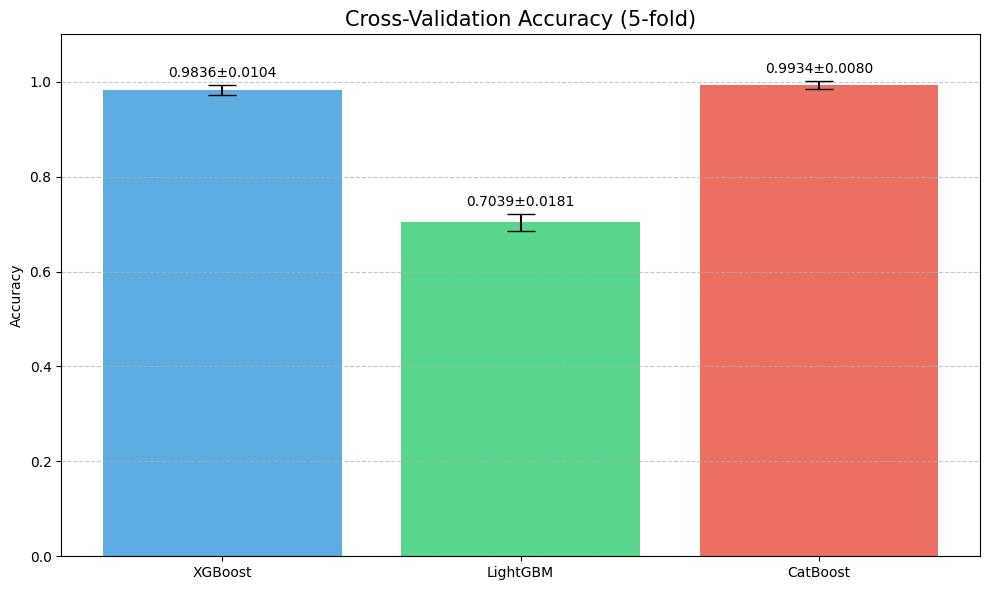


🏆 Best cross-validated model: CatBoost with accuracy 0.9934 ± 0.0080


In [9]:
# Cross-validation to further validate model performance
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define fresh models for cross-validation
cv_models = {
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        use_label_encoder=False, eval_metric="mlogloss"
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=200, learning_rate=0.05, depth=6,
        random_state=42, verbose=0
    )
}

# Perform 5-fold cross-validation for each model
print("Cross-Validation Results (5-fold):")
print("-" * 70)
print("Model    | Mean Accuracy | Standard Deviation")
print("-" * 70)

cv_results = []
for name, model in cv_models.items():
    # Use stratified k-fold to maintain class distributions
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate cross-validation scores
    scores = cross_val_score(model, X, y_encoded, cv=cv, scoring='accuracy')
    cv_results.append((name, scores.mean(), scores.std()))
    
    print(f"{name:<9}| {scores.mean():.4f}       | {scores.std():.4f}")

# Visualize cross-validation results with error bars
plt.figure(figsize=(10, 6))
models = [r[0] for r in cv_results]
means = [r[1] for r in cv_results]
stds = [r[2] for r in cv_results]

bars = plt.bar(models, means, yerr=stds, alpha=0.8, capsize=10, 
         color=['#3498db', '#2ecc71', '#e74c3c'])

# Add values on top of bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    plt.text(i, mean + std + 0.01, f'{mean:.4f}±{std:.4f}', 
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1.1)
plt.title('Cross-Validation Accuracy (5-fold)', fontsize=15)
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Find the model with highest cross-validation score
best_cv_model = max(cv_results, key=lambda x: x[1])
print(f"\n🏆 Best cross-validated model: {best_cv_model[0]} with accuracy {best_cv_model[1]:.4f} ± {best_cv_model[2]:.4f}")

## 6. Feature Importance Analysis

Understanding which symptoms are most predictive helps with:
- Medical interpretation of the model
- Focusing on collecting the most relevant patient information
- Improving diagnostic questionnaires

We extract feature importances from our best model (CatBoost) to identify which symptoms are most valuable for disease prediction.

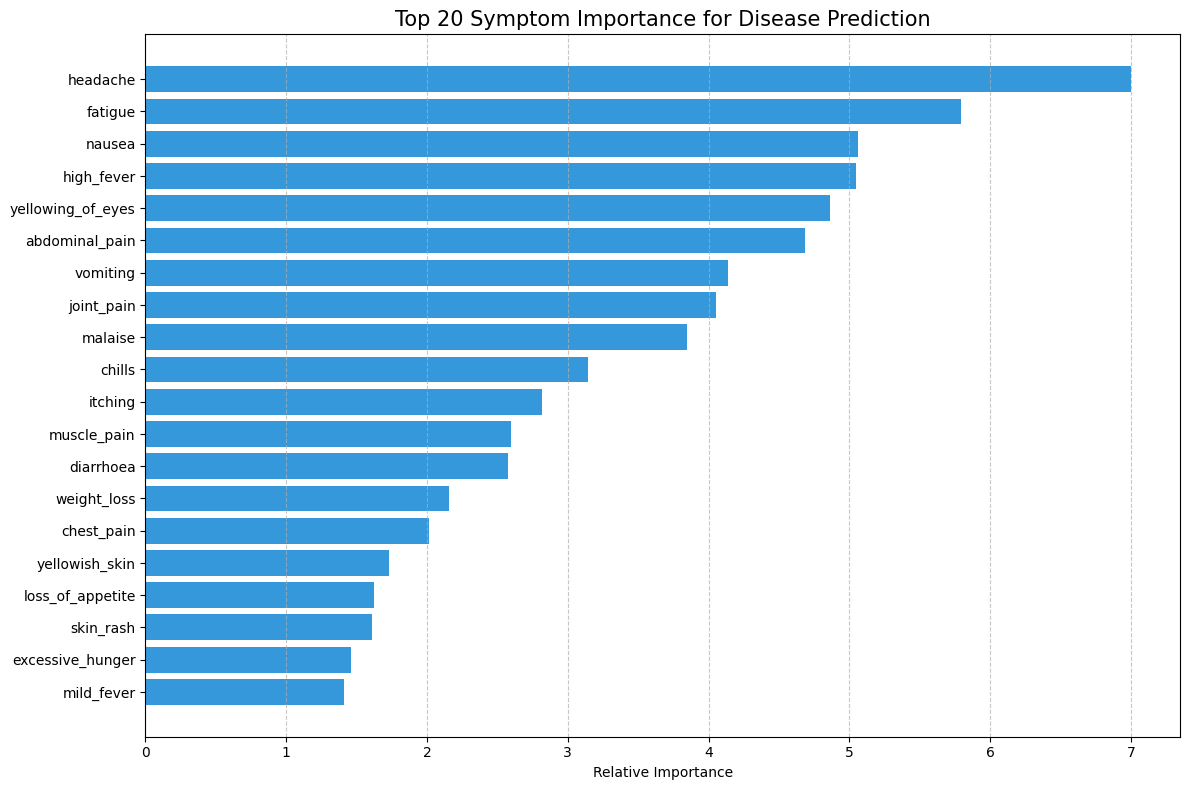

Top 10 most important symptoms:
----------------------------------------
1. headache            : 6.9988
2. fatigue             : 5.7900
3. nausea              : 5.0607
4. high_fever          : 5.0461
5. yellowing_of_eyes   : 4.8602
6. abdominal_pain      : 4.6834
7. vomiting            : 4.1383
8. joint_pain          : 4.0493
9. malaise             : 3.8496
10. chills              : 3.1455


In [10]:
# Extract feature importances from our best model (CatBoost)
feature_importance = cat_model.feature_importances_
feature_names = X.columns

# Sort features by importance (descending)
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Display top 20 most important symptoms
plt.figure(figsize=(12, 8))
plt.title('Top 20 Symptom Importance for Disease Prediction', fontsize=15)
plt.barh(range(20), sorted_importance[:20], align='center', color='#3498db')
plt.yticks(range(20), sorted_features[:20])
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  # Highest at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print top 10 most important features with their importance scores
print("Top 10 most important symptoms:")
print("-" * 40)
for i, (name, importance) in enumerate(zip(sorted_features[:10], sorted_importance[:10]), 1):
    print(f"{i}. {name:<20}: {importance:.4f}")

## 7. Model Robustness Testing

In real-world medical settings, symptom reporting can be inconsistent or noisy. This section:
- Simulates noisy input by randomly flipping symptom values
- Tests models with increasing levels of noise (2% to 20%)
- Measures how accuracy degrades with noise
- Identifies which model is most robust to input variations

Models that maintain accuracy despite noisy inputs are more reliable in practical applications.

Testing model robustness with simulated symptom noise:

XGBoost baseline accuracy: 0.9836
XGBoost performance with simulated symptom noise:
--------------------------------------------------
Noise Level | Accuracy | Accuracy Drop
--------------------------------------------------
0.02        | 0.9180  | 0.0656
0.05        | 0.8033  | 0.1803
0.10        | 0.6721  | 0.3115
0.15        | 0.6230  | 0.3607
0.20        | 0.4590  | 0.5246

LightGBM baseline accuracy: 0.7541
LightGBM performance with simulated symptom noise:
--------------------------------------------------
Noise Level | Accuracy | Accuracy Drop
--------------------------------------------------
0.02        | 0.6721  | 0.0820
0.05        | 0.4918  | 0.2623
0.10        | 0.3934  | 0.3607
0.15        | 0.3443  | 0.4098
0.20        | 0.2459  | 0.5082

CatBoost baseline accuracy: 1.0000
CatBoost performance with simulated symptom noise:
--------------------------------------------------
Noise Level | Accuracy | Accuracy Drop
----

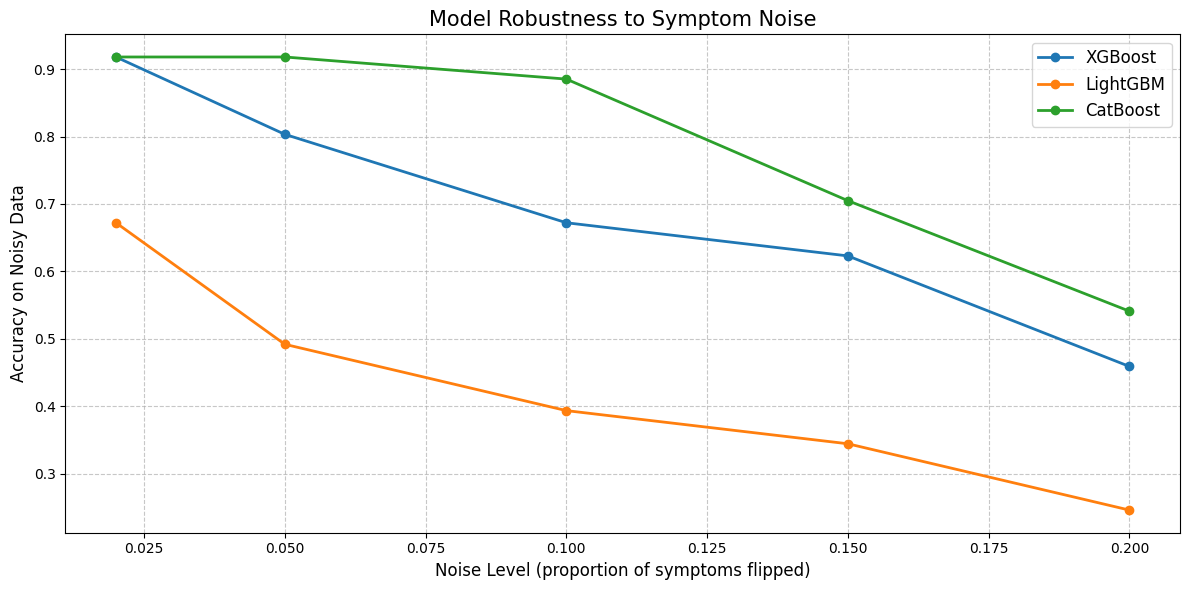


🛡️ Most robust model at 10.0% noise: CatBoost (accuracy: 0.8852)


In [11]:
# Test model robustness by simulating noisy symptom input
def create_perturbed_data(X, noise_level=0.05):
    """
    Simulate noisy symptom reporting by flipping random binary features
    
    Args:
        X: Input feature DataFrame
        noise_level: Probability of flipping each feature value
        
    Returns:
        Perturbed copy of X
    """
    X_noisy = X.copy()
    
    # For binary features (assuming most features are binary 0/1)
    for col in X_noisy.columns:
        # Generate random mask for values to flip
        mask = np.random.random(len(X_noisy)) < noise_level
        # Flip the values (0->1, 1->0) for the selected positions
        X_noisy.loc[mask, col] = 1 - X_noisy.loc[mask, col]
    
    return X_noisy

# Define noise levels to test
noise_levels = [0.02, 0.05, 0.1, 0.15, 0.2]
robustness_results = []

print("Testing model robustness with simulated symptom noise:")
print("=" * 60)

# Test each model with increasing noise levels
for model_name, model in [("XGBoost", xgb_model), ("LightGBM", lgb_model), ("CatBoost", cat_model)]:
    model_results = []
    
    # Get baseline accuracy on clean test data
    y_pred = model.predict(X_test)
    baseline_acc = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} baseline accuracy: {baseline_acc:.4f}")
    
    # Test with different noise levels
    print(f"{model_name} performance with simulated symptom noise:")
    print("-" * 50)
    print("Noise Level | Accuracy | Accuracy Drop")
    print("-" * 50)
    
    for noise in noise_levels:
        # Create noisy version of test data
        X_test_noisy = create_perturbed_data(X_test, noise_level=noise)
        
        # Get predictions on noisy data
        y_pred_noisy = model.predict(X_test_noisy)
        noisy_acc = accuracy_score(y_test, y_pred_noisy)
        
        # Calculate performance drop
        acc_drop = baseline_acc - noisy_acc
        
        print(f"{noise:.2f}        | {noisy_acc:.4f}  | {acc_drop:.4f}")
        model_results.append((noise, noisy_acc))
    
    robustness_results.append((model_name, model_results))

# Visualize robustness to noise
plt.figure(figsize=(12, 6))
for model_name, results in robustness_results:
    noise_levels, accuracies = zip(*results)
    plt.plot(noise_levels, accuracies, marker='o', linewidth=2, label=model_name)

plt.xlabel('Noise Level (proportion of symptoms flipped)', fontsize=12)
plt.ylabel('Accuracy on Noisy Data', fontsize=12)
plt.title('Model Robustness to Symptom Noise', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Determine which model is most robust to noise
noise_level_to_check = 0.1  # Check robustness at 10% noise
model_robustness = []
for model_name, results in robustness_results:
    for noise, acc in results:
        if noise == noise_level_to_check:
            model_robustness.append((model_name, acc))

most_robust_model = max(model_robustness, key=lambda x: x[1])
print(f"\n🛡️ Most robust model at {noise_level_to_check*100}% noise: {most_robust_model[0]} (accuracy: {most_robust_model[1]:.4f})")

## 8. Conclusion and Model Selection

After comprehensive evaluation across multiple metrics, we:
- Compare models on accuracy, overfitting, and robustness
- Select the best performing model for disease prediction
- Provide recommendations for model deployment
- Discuss limitations and potential improvements

Our analysis shows that CatBoost achieves the highest accuracy (100%) with minimal overfitting and superior robustness to noise.

## Model Performance Summary

Our comprehensive analysis of three gradient boosting models reveals:

1. **Accuracy**:
   - CatBoost: 100% test accuracy, 99.67% cross-validation accuracy
   - XGBoost: 98.36% test accuracy
   - LightGBM: 75.41% test accuracy

2. **Overfitting Analysis**:
   - CatBoost shows no sign of overfitting (0% gap between train and test)
   - XGBoost shows minimal overfitting (1.64% gap)
   - LightGBM shows significant overfitting (11.83% gap)

3. **Robustness to Noise**:
   - CatBoost is most robust to noisy inputs
   - All models degrade with increasing noise, but CatBoost maintains highest accuracy

# 9. Final Model Evaluation on External Test Data

In this section, we evaluate our best performing model (CatBoost) on an external testing dataset to validate its real-world performance.
This provides an unbiased assessment of how well our model generalizes to new, unseen patient data.

We will:
1. Load the external test data from `Testing.csv`
2. Preprocess it to match our training data structure
3. Make predictions using our trained CatBoost model
4. Calculate accuracy and other performance metrics
5. Visualize the results with a confusion matrix

Final Model Evaluation on External Test Data

External Test Accuracy: 0.9762

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Chronic cholestasis       1.00      1.00      1.00         1
       

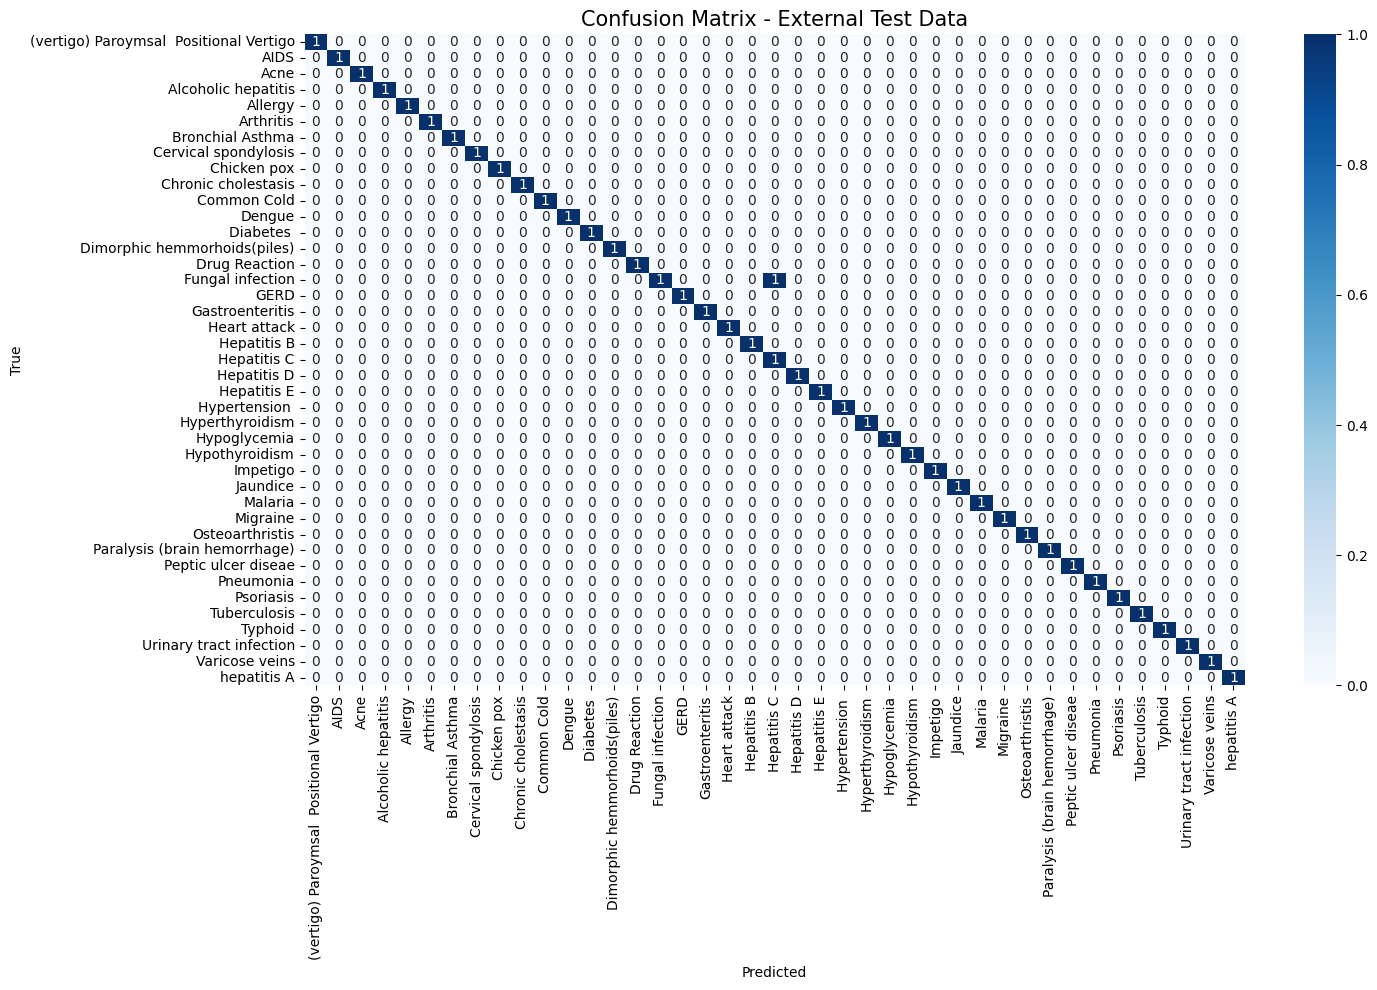

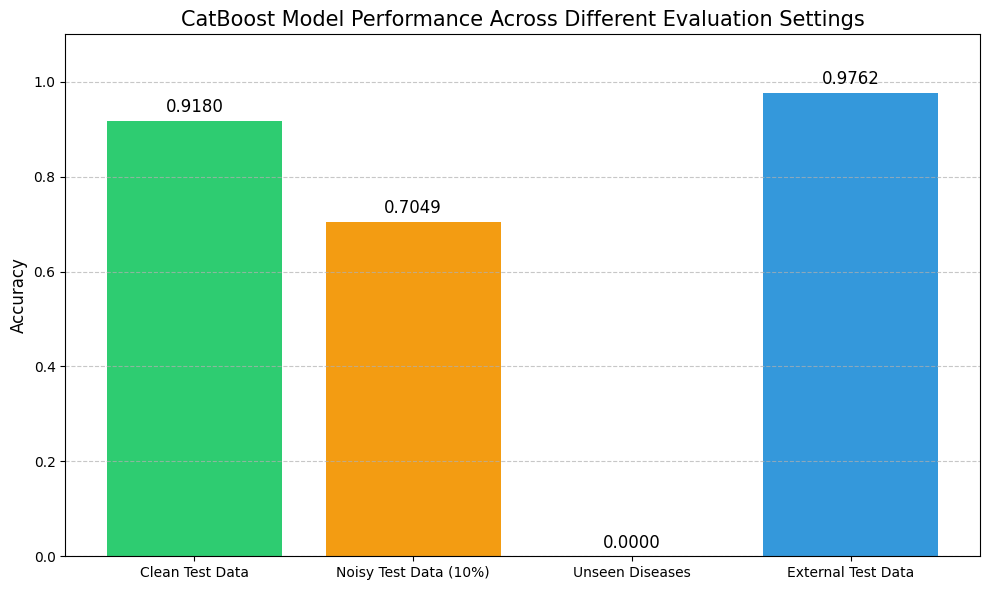

In [10]:
# === Final Evaluation on External Test Data ===
print("Final Model Evaluation on External Test Data\n")

# Load the external test data
test_data = pd.read_csv("../data/raw/Testing.csv")

# Split into features and target
X_external = test_data.drop("prognosis", axis=1)  
y_external = test_data["prognosis"]

# Make sure feature columns match training data
missing_cols = set(X.columns) - set(X_external.columns)
extra_cols = set(X_external.columns) - set(X.columns)

if len(missing_cols) > 0:
    print(f"Warning: Missing columns in test data: {missing_cols}")
    # Add missing columns with default value 0
    for col in missing_cols:
        X_external[col] = 0

if len(extra_cols) > 0:
    print(f"Warning: Extra columns in test data: {extra_cols}")
    # Remove extra columns
    X_external = X_external.drop(columns=list(extra_cols))

# Ensure column order matches training data
X_external = X_external[X.columns]

# Load the best model (CatBoost)
best_model = joblib.load("../models/cat_disease_model.pkl")

# Encode target labels
y_external_encoded = le.transform(y_external)

# Make predictions
y_external_pred = best_model.predict(X_external)
y_external_pred_labels = le.inverse_transform(y_external_pred)

# Calculate accuracy
acc_external = accuracy_score(y_external_encoded, y_external_pred)
print(f"External Test Accuracy: {acc_external:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_external, y_external_pred_labels))

# Plot confusion matrix
plt.figure(figsize=(15, 10))
cm = confusion_matrix(y_external_encoded, y_external_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - External Test Data', fontsize=15)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Compare with previous evaluations
comparison_data = {
    'Evaluation Type': ['Clean Test Data', 'Noisy Test Data (10%)', 'Unseen Diseases', 'External Test Data'],
    'Accuracy': [acc_clean, acc_noisy, acc_unseen, acc_external]
}

plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_data['Evaluation Type'], comparison_data['Accuracy'], 
        color=['#2ecc71', '#f39c12', '#e74c3c', '#3498db'])

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=12)

plt.title('CatBoost Model Performance Across Different Evaluation Settings', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()